# Multiclass image classification using Transfer learning
Importing necessary Libraries

In [1]:
 import numpy as np
 import pandas as pd
 import seaborn as sns
 import matplotlib.pyplot as plt

 from sklearn.metrics import classification_report,confusion_matrix

 # Deep learning libraries
 import tensorflow as tf
 import keras
 from keras.preprocessing.image import ImageDataGenerator
 from tensorflow.keras import applications
 from keras.models import Sequential, load_model
 from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
 from keras.preprocessing import image

 import cv2

 import warnings
 warnings.filterwarnings('ignore')

## Loading Data and image folders
from the Google drive we will load the data : https://drive.google.com/drive/folders/1z31bsh7gNrUiwameOEWhqtWNZuKEdKQ7?usp=sharing

using this data set without downloading
  - you will fast mount your drive on colab using the code
  {from google.colab import drive
drive.mount('/content/drive')}
  - after mounting you will organize the folder and select add shortcut by this you will add a short cut to your main drive folder. and by using the code below you can access the data and use it on your colab notebook

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Datasets
labels = pd.read_csv("/content/drive/My Drive/Colab Notebooks/datasets_dog_breed_classification/labels.csv")


# folders paths
train_pathss = "/content/drive/MyDrive/Colab Notebooks/datasets_dog_breed_classification/train"
test_path = "/content/drive/MyDrive/Colab Notebooks/datasets_dog_breed_classification/test"

first 5 records of the labels

In [4]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Adding ‘.jpg’ extension to each id

I did this in order to fetch the images from the folder since the image name and id’s are the same so adding .jpg extension will help us in retrieving images easily.

In [5]:
def to_jpg(id):
  return id+".jpg"

labels['id'] = labels['id'].apply(to_jpg)

No of images befor the filtering of the images by spliting the labels in half to be able to train the model in the limited resources i have

In [6]:
import os

# List all files in the directory
files = os.listdir(train_pathss)

# Filter the list to include only image files
image_filess = [file for file in files if file.endswith(('.png', '.jpg', '.jpeg'))]

# Print the number of image files
print("Number Images before filtering :",len(image_filess))

# Get the unique breeds
num_breeds = labels['breed'].nunique()

print("Number of Unique breeds before filtering: ",num_breeds)


Number Images before filtering : 10222
Number of Unique breeds before filtering:  120


By using the code below I will Divide the data for training in Half this will be to maximize the processing power that i do have this will reduce the number of classes that i have by half.

the half selected breeds will then be used to filter the image folder so as to only extract images that are important in the training of the model.

In [7]:
import shutil

# Get the unique breeds
unique_breeds = labels['breed'].unique()

# Randomly select 60 breeds
selected_breeds = np.random.choice(unique_breeds, size=60, replace=False)

# Filter the DataFrame based on the selected breeds
labels = labels[labels['breed'].isin(selected_breeds)]

# Save the new DataFrame
labels.to_csv('labels.csv', index=False)

# Create a new directory for the selected images
os.makedirs('train_path', exist_ok=True)

# Copy the selected images to the new directory
for file_name in labels['id']:
    shutil.copy(os.path.join(train_pathss, file_name), 'train_path')


Checking the number of Classes(Breeds) that i still have in the data after filtering

In [8]:
# Specify the path
train_path = 'train_path'  # replace with your path

# List all files in the directory
files = os.listdir(train_path)

# Filter the list to include only image files
image_files = [file for file in files if file.endswith(('.png', '.jpg', '.jpeg'))]

# Print the number of image files
print("Number Images After filtering :",len(image_files))

# Get the unique breeds
num_breeds = labels['breed'].nunique()

print("Number of Unique breeds After filtering: ",num_breeds)

Number Images After filtering : 5149
Number of Unique breeds After filtering:  60


## Augmenting Data


In [9]:
# Data Agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(rescale = 1./255.,
                         horizontal_flip = True,
                         validation_split= 0.2 # training: 80% data and testing 20%
                         )
train_generator = gen.flow_from_dataframe(labels, #Dataframe
                                          directory = train_path,
                                          x_col = 'id',
                                          y_col = 'breed',
                                          subset = 'training',
                                          color_mode = 'rgb',
                                          target_size = (331, 331), # image hight, image width
                                          class_mode = 'categorical',
                                          batch_size = 32,
                                          shuffle = True,
                                          seed = 42,)
validation_generator = gen.flow_from_dataframe(labels, #Dataframe
                                               directory = train_path, # image path
                                               x_col ='id',
                                               y_col = 'breed',
                                               subset = 'validation',
                                               color_mode= 'rgb',
                                               traget_size = (331, 331),
                                               class_mode = 'categorical',
                                               batch_size = 32,
                                               shuffle = True,
                                               seed =42,)



Found 4120 validated image filenames belonging to 60 classes.
Found 1029 validated image filenames belonging to 60 classes.


In [10]:
# view a single batch of data looks like
x, y = next(train_generator)
x.shape # input shape of one recored is (331, 331, 3), 32: is the batchsize

(32, 331, 331, 3)

## Plotting images from train dataset

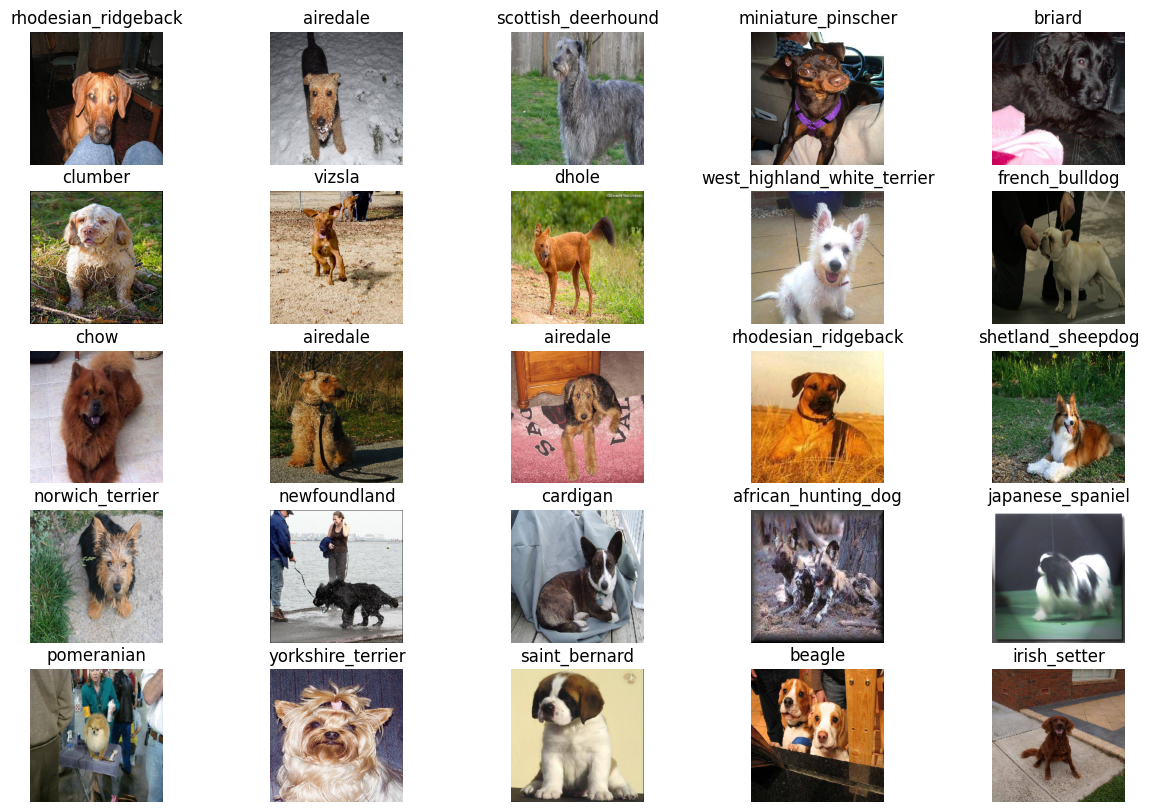

In [11]:
a = train_generator.class_indices
class_names = list(a.keys()) # Storring class/breed names in a list

def plot_images (img, labels):
  plt.figure(figsize = [15, 10])
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(img[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')

plot_images(x,y)

## Building The Model

In [12]:
# Load the InceptionResNetV2 architecture  with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(include_top = False,
                                                     weights = 'imagenet',
                                                     input_shape = (331, 331, 3))
base_model.trainable = False
""" For freezing the layer we make use of layer.trainable = False  this means that its internal state will not change during training.
    model's trainable weights will not be updated during fit(), and also its state updates will not run.
"""

model = tf.keras.Sequential([base_model,
                             tf.keras.layers.BatchNormalization(renorm = True),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(512, activation = 'relu'),
                             tf.keras.layers.Dense(256, activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(128, activation = 'relu'),
                             tf.keras.layers.Dense(60, activation = 'softmax') ## Change the output in the oder of howmany classes you have I have 60 claases
                             ])

219055592/219055592 [==============================] - 1s 0us/step


### Compile The Model

In [13]:

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

""" I chose to use categorical cross entropy because it's an effective loss function for multi-class classification problems
   where there are two or more output labels. To enhance performance, I'm utilizing the Adam optimizer,
   although other optimizers like SGD could also be suitable depending on the model. """


" I chose to use categorical cross entropy because it's an effective loss function for multi-class classification problems\n   where there are two or more output labels. To enhance performance, I'm utilizing the Adam optimizer,\n   although other optimizers like SGD could also be suitable depending on the model. "

In [14]:
# Summary report of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 9, 9, 1536)        54336736  
 ional)                                                          
                                                                 
 batch_normalization_203 (B  (None, 9, 9, 1536)        10752     
 atchNormalization)                                              
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

### Defining Callbacks To preserve the best results

In [15]:

# early stopping call back
early = tf.keras.callbacks.EarlyStopping(patience = 10,
                                         min_delta = 0.001,
                                         restore_best_weights = True)


## Training Model
in this I am trying to find a set of values for weights and biases that have low loss on average across all the records

In [16]:
batch_size = 32
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

#fit model
history = model.fit(train_generator, steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = validation_generator,
                    validation_steps =  STEP_SIZE_VALID,
                    epochs =  25,
                    callbacks = [early])


Epoch 1/25
128/128 [==============================] - 99s 584ms/step - loss: 1.1373 - accuracy: 0.7564 - val_loss: 0.6515 - val_accuracy: 0.9082
Epoch 2/25
128/128 [==============================] - 56s 439ms/step - loss: 0.2649 - accuracy: 0.9283 - val_loss: 0.6541 - val_accuracy: 0.9092
Epoch 3/25
128/128 [==============================] - 57s 445ms/step - loss: 0.2414 - accuracy: 0.9403 - val_loss: 0.6973 - val_accuracy: 0.9199
Epoch 4/25
128/128 [==============================] - 57s 447ms/step - loss: 0.1918 - accuracy: 0.9484 - val_loss: 0.7245 - val_accuracy: 0.9189
Epoch 5/25
128/128 [==============================] - 54s 419ms/step - loss: 0.1601 - accuracy: 0.9513 - val_loss: 0.7595 - val_accuracy: 0.9092
Epoch 6/25
128/128 [==============================] - 55s 427ms/step - loss: 0.1472 - accuracy: 0.9579 - val_loss: 0.8354 - val_accuracy: 0.9248
Epoch 7/25
128/128 [==============================] - 57s 448ms/step - loss: 0.1464 - accuracy: 0.9591 - val_loss: 0.8171 - val_ac

## Save Model

In [17]:
model.save('Model.h5')

### Visualize The models Performance

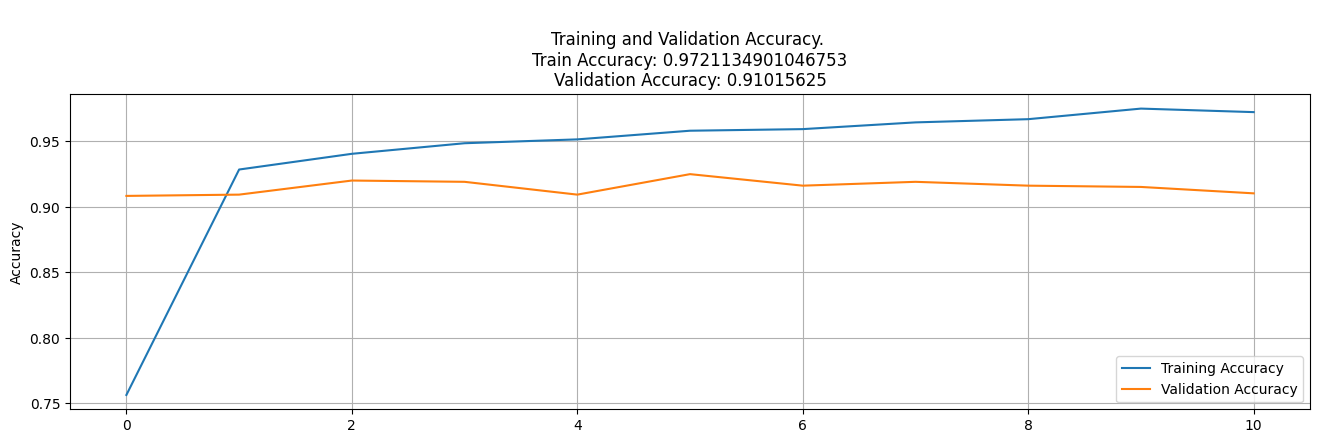

In [18]:
# Store results
acc =  history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot results
# accuracy
plt.figure(figsize=(16, 9), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {acc[-1]}\nValidation Accuracy: {val_acc[-1]}')
plt.grid(True)
plt.show()

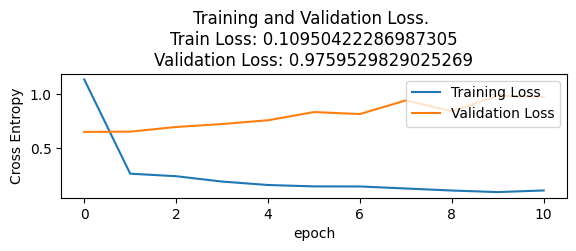

In [19]:
# Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

The graph indicates that the accuracies of validation and training were almost consistent with each other and above 90%. The loss of the CNN model is a negative lagging graph which indicates that the model is behaving as expected with a reducing loss after each epoch.

## Evaluating the Accuracy of the model

In [20]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1]* 100))
print('Loss: ', accuracy_score[0])

33/33 [==============================] - 10s 299ms/step - loss: 0.6536 - accuracy: 0.9155
[0.6535611152648926, 0.9154518842697144]
Accuracy: 91.5452%
Loss:  0.6535611152648926


### Viewing Test Image

In [21]:
test_img_path = test_path+"/000621fb3cbb32d8935728e48679680e.jpg"

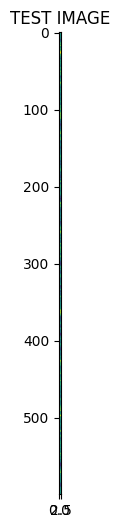

In [31]:
img = cv2.imread(test_img_path)
resized_img = cv2.imread(test_img_path)

plt.figure(figsize = (16,6))
plt.title('TEST IMAGE')
plt.imshow(resized_img[0])

## Making Predictions on the Test data

In [23]:
import os
file_names = os.listdir(test_path)

# image_file_names is your list of file names
image_file_names = [file for file in file_names if file.endswith(('.png', '.jpg', '.jpeg'))]

# Create a DataFrame
df_sample = pd.DataFrame(image_file_names, columns=['id'])

# Print the DataFrame
print(df_sample)

                                         id
0      e76a7a1d23d687b5015b07df762c0c10.jpg
1      e78b4a09e5f86c330e24c6aaed63f0be.jpg
2      e715c53e3d189a20760ef4d891a865dc.jpg
3      e83f4c0ff6dec86d89d0f8b70ecd3cea.jpg
4      e8899ab63ea8630d50f0b321cb4bf811.jpg
...                                     ...
10355  0890c992ea2d00c3c2de9e588081a3b9.jpg
10356  088caa7edc676bfd9ecb154e1cb4d720.jpg
10357  07ec68dd37d6b9f89e551820f5ca946f.jpg
10358  08d5f16507943be640f4592c9d08a798.jpg
10359  088463756041ddbc5f9b905b6ed9a940.jpg

[10360 rows x 1 columns]


In [ ]:
predictions = []

for image in df_sample['id']:
    img = tf.keras.preprocessing.image.load_img(test_path +'/'+ image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (331, 331))
    img = tf.reshape(img, (-1, 331, 331, 3))
    prediction = model.predict(img/255)
    predictions.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': df_sample['id'], 'label':  predictions})
my_submission.to_csv('submission.csv', index=False)

In [26]:
# Submission file output
print("Submission File: \n---------------\n")
print(my_submission.head()) # Displaying first five predicted output

Submission File: 
---------------

                               image_id  label
0  e76a7a1d23d687b5015b07df762c0c10.jpg     43
1  e78b4a09e5f86c330e24c6aaed63f0be.jpg     53
2  e715c53e3d189a20760ef4d891a865dc.jpg      3
3  e83f4c0ff6dec86d89d0f8b70ecd3cea.jpg     50
4  e8899ab63ea8630d50f0b321cb4bf811.jpg     34


In [33]:
# Assuming `labels_df` is your DataFrame containing the labels
index_to_breed = labels.reset_index().set_index('index')['breed'].to_dict()

# Add a 'breed' column to the submission DataFrame
my_submission['breed'] = my_submission['label'].map(index_to_breed)

# Save the updated DataFrame
my_submission.to_csv('submission_with_breeds.csv', index=False)

# Print the updated DataFrame
print("Updated Submission File: \n---------------\n")
print(my_submission.head())


Updated Submission File: 
---------------

                               image_id  label                breed
0  e76a7a1d23d687b5015b07df762c0c10.jpg     43                  NaN
1  e78b4a09e5f86c330e24c6aaed63f0be.jpg     53  irish_water_spaniel
2  e715c53e3d189a20760ef4d891a865dc.jpg      3             bluetick
3  e83f4c0ff6dec86d89d0f8b70ecd3cea.jpg     50  african_hunting_dog
4  e8899ab63ea8630d50f0b321cb4bf811.jpg     34                  NaN


# N/B
Note: The model’s performance on the test data was not optimal due to the reduction of data classes from 120 to 60. This means the model was not trained on some images. A significant challenge encountered was the limited processing power and the restricted time allocated to the free GPU in Google Colab. Despite these constraints, I successfully trained the pre-trained model, InceptionResNetV2, achieving an accuracy of 91.5452% and a loss of 0.6535611152648926.

By Joseph Wathome